In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

In [2]:
stock_symbols = ['ONCO', 'CNEY', 'TNXP', 'APLD', 'KTTA']


In [3]:
stock_data = {}

# Loop through each stock symbol and download the historical data
for symbol in stock_symbols:
    stock_data[symbol] = yf.download(symbol, start="2020-01-01", end="2024-09-26", progress=False)

print(stock_data['ONCO'].head())  # Shows the first few rows of ONCO's stock data


                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2022-02-18  2000.000000  2300.000000  1520.000000  2296.000000  2296.000000   
2022-02-22  2700.000000  3636.000000  2004.000000  2278.800049  2278.800049   
2022-02-23  1895.599976  2072.000000  1302.000000  1992.000000  1992.000000   
2022-02-24  1600.800049  1780.000000  1459.199951  1712.199951  1712.199951   
2022-02-25  1559.599976  1779.599976  1504.479980  1774.000000  1774.000000   

            Volume  
Date                
2022-02-18    3295  
2022-02-22    2683  
2022-02-23    1478  
2022-02-24    1080  
2022-02-25     903  


In [4]:
# Create a DataFrame with Adjusted Closing Prices for all stocks
stock_prices = pd.DataFrame()

for symbol in stock_symbols:
    stock_prices[symbol] = stock_data[symbol]['Adj Close']

print(stock_prices.head())


                   ONCO       CNEY    TNXP  APLD       KTTA
Date                                                       
2022-02-18  2296.000000  55.200001  1152.0   NaN  21.799999
2022-02-22  2278.800049  57.599998  1152.0   NaN  20.799999
2022-02-23  1992.000000  60.299999  1088.0   NaN  20.400000
2022-02-24  1712.199951  56.400002  1152.0   NaN  19.400000
2022-02-25  1774.000000  56.400002  1152.0   NaN  20.400000


In [6]:
# SAVE data for observation as csv
stock_prices.to_csv('/users/hm4th/desktop/stock_prices.csv', index=True)


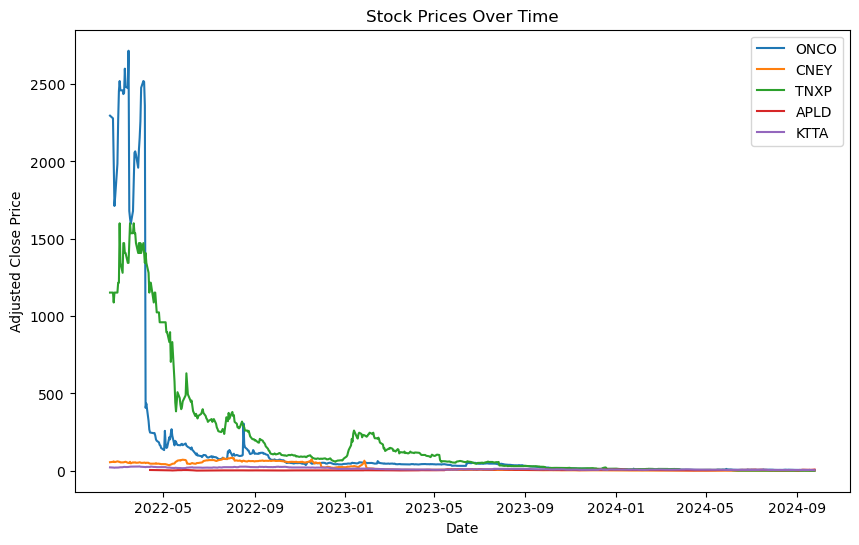

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
for symbol in stock_symbols:
    plt.plot(stock_prices.index, stock_prices[symbol], label=symbol)

plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()


In [8]:
for symbol in stock_symbols:
    stock_prices[f'{symbol}_target'] = (stock_prices[symbol].diff() > 0).astype(int)

stock_prices.head()


,ONCO,CNEY,TNXP,APLD,KTTA,ONCO_target,CNEY_target,TNXP_target,APLD_target,KTTA_target
Date,,,,,,,,,,
2022-02-18,2296.000000,55.200001,1152.0,NaN,21.799999,0,0,0,0,0
2022-02-22,2278.800049,57.599998,1152.0,NaN,20.799999,0,1,0,0,0
2022-02-23,1992.000000,60.299999,1088.0,NaN,20.400000,0,1,0,0,0
2022-02-24,1712.199951,56.400002,1152.0,NaN,19.400000,0,0,1,0,0
2022-02-25,1774.000000,56.400002,1152.0,NaN,20.400000,1,0,0,0,1


In [15]:
import tweepy

consumer_key = "BOSkxRVEXgli0koFm7NhBXfXD"
consumer_secret = "qbd7l1amAofLj7RTABsq8BWwjYcHK5RfL7MzvYlRjtuxyONbU1"
access_token = "1045465932-NMUbzS8EMC8tjoaNHH8Xm20gwdG1mVsl0cfRwqs"  # You will need to generate this if you haven't
access_token_secret = "8AuI9YoleC1v3RGmenzaIaUmpmhYHJUMRrYDRnx1o5kNK"  # You will need to generate this if you haven't

auth = tweepy.OAuth1UserHandler(consumer_key, consumer_secret, access_token, access_token_secret)

# Create an API object
api = tweepy.API(auth)

user = api.verify_credentials()
if user:
    print("Authentication successful!")
else:
    print("Authentication failed.")


Authentication successful!


In [6]:
import requests
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

news_api_key = 'd4f5a637a7f54525bf11236c368f7561'

stocks = ['$ONCO', '$CNEY', '$TNXP', '$APLD', '$KTTA']

def fetch_stock_news(stock_symbol):
    url = f"https://newsapi.org/v2/everything?q={stock_symbol}&sortBy=publishedAt&apiKey={news_api_key}"
    response = requests.get(url)
    return response.json()

analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(articles):
    sentiment_results = []
    for article in articles:
        title = article['title']
        description = article['description']
        content = article.get('content', '')
        text = f"{title}. {description}. {content}"
        
        # Get the sentiment score using VADER
        sentiment_score = analyzer.polarity_scores(text)
        
        # Classify the sentiment significance
        compound_score = sentiment_score['compound']
        if compound_score > 0.5:
            significance = 'Strongly Positive'
        elif 0 < compound_score <= 0.5:
            significance = 'Moderately Positive'
        elif -0.5 < compound_score <= 0:
            significance = 'Moderately Negative'
        else:
            significance = 'Strongly Negative'
        
        # Append the sentiment results
        sentiment_results.append({
            'title': title,
            'description': description,
            'content': content,
            'author': article.get('author', 'Unknown'),
            'source': article['source']['name'],
            'sentiment_score': compound_score,
            'sentiment_positive': sentiment_score['pos'],
            'sentiment_negative': sentiment_score['neg'],
            'sentiment_neutral': sentiment_score['neu'],
            'significance': significance,
            'published_at': article['publishedAt']
        })
    
    return sentiment_results

# Collect and analyze news articles for all stocks
all_articles = []
for stock in stocks:
    stock_news = fetch_stock_news(stock)
    if stock_news['status'] == 'ok':
        sentiment_results = analyze_sentiment(stock_news['articles'])
        all_articles.extend(sentiment_results)

# Create a Pandas DataFrame
df = pd.DataFrame(all_articles)

# Display the first few rows of the DataFrame
print(df.head(200))

# Save the DataFrame to a CSV file
df.to_csv('/users/hm4th/desktop/stock_sentiment_analysis2.csv', index=False)


                                                title  \
0   BioSenic announces that it has started to look...   
1             BioSenic reports half year 2024 results   
2            Programming cells to target brain tumors   
3   Tumori del sangue, con terapia Car-T il percor...   
4   Combination of bortezomib and venetoclax targe...   
..                                                ...   
66  Pasithea Therapeutics Announces Positive Initi...   
67  Pasithea Therapeutics Corp. (NASDAQ:KTTA) Shor...   
68  Pasithea reports positive results in PAS-004 t...   
69  Pasithea Therapeutics Announces Successful Com...   
70  Pasithea Therapeutics Announces Appointment of...   

                                          description  \
0   PRIVILEGED INFORMATION      Biosenic and Globa...   
1   REGULATED INFORMATIONThe interim financial rep...   
2   Glioblastoma is the most common and most aggre...   
3   Descrizione contenuto Tumori del sangue, con t...   
4   Author summary Epstein-Bar

In [16]:
import yfinance as yf
import pandas as pd
import os

# List of stock symbols
stocks = ['ONCO', 'CNEY', 'TNXP', 'APLD', 'KTTA']

# Directory where you want to save the CSV files (your desktop)
save_directory = '/users/hm4th/desktop'

# Ensure the directory exists
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Function to calculate RSI (Relative Strength Index)
def calculate_rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

# Function to fetch stock data and calculate technical indicators
def get_stock_data(stock_symbol):
    # Fetch historical stock data
    stock = yf.Ticker(stock_symbol)
    hist = stock.history(period="1y")  # 1 year of historical data
    
    # Calculate 50-day and 200-day Moving Averages
    hist['MA50'] = hist['Close'].rolling(window=50).mean()
    hist['MA200'] = hist['Close'].rolling(window=200).mean()
    
    # Calculate RSI (Relative Strength Index)
    hist['RSI'] = calculate_rsi(hist)
    
    # Calculate Volatility (standard deviation of price returns)
    hist['Volatility'] = hist['Close'].pct_change().rolling(window=21).std() * (21**0.5)
    
    return hist

# Loop through each stock, calculate indicators, and save to CSV
for stock in stocks:
    stock_data = get_stock_data(stock)
    
    # Create the CSV file path on the desktop
    csv_filename = os.path.join(save_directory, f'{stock}_technical_indicators.csv')
    
    # Save the stock data with technical indicators to the CSV file
    stock_data.to_csv(csv_filename)
    
    print(f"Technical indicators for {stock} saved to '{csv_filename}'")


Technical indicators for ONCO saved to '/users/hm4th/desktop/ONCO_technical_indicators.csv'
Technical indicators for CNEY saved to '/users/hm4th/desktop/CNEY_technical_indicators.csv'
Technical indicators for TNXP saved to '/users/hm4th/desktop/TNXP_technical_indicators.csv'
Technical indicators for APLD saved to '/users/hm4th/desktop/APLD_technical_indicators.csv'
Technical indicators for KTTA saved to '/users/hm4th/desktop/KTTA_technical_indicators.csv'


In [18]:
import yfinance as yf
import pandas as pd
import os
from fredapi import Fred

# Your FRED API Key
fred_api_key = 'c25b738d4b0b4944087469f21ab02241'
fred = Fred(api_key=fred_api_key)

# List of stock symbols
stocks = ['ONCO', 'CNEY', 'TNXP', 'APLD', 'KTTA']

# Directory where you want to save the CSV files (your desktop)
save_directory = '/users/hm4th/desktop'

# Ensure the directory exists
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Function to calculate RSI (Relative Strength Index)
def calculate_rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

# Function to fetch stock data and calculate technical indicators
def get_stock_data(stock_symbol):
    # Fetch historical stock data
    stock = yf.Ticker(stock_symbol)
    hist = stock.history(period="1y")  # 1 year of historical data
    
    # Calculate 50-day and 200-day Moving Averages
    hist['MA50'] = hist['Close'].rolling(window=50).mean()
    hist['MA200'] = hist['Close'].rolling(window=200).mean()
    
    # Calculate RSI (Relative Strength Index)
    hist['RSI'] = calculate_rsi(hist)
    
    # Calculate Volatility (standard deviation of price returns)
    hist['Volatility'] = hist['Close'].pct_change().rolling(window=21).std() * (21**0.5)
    
    # Fetch the trading volume and add to the DataFrame (already provided by yfinance)
    
    return hist

# Function to fetch macro-economic data from FRED
def get_macro_economic_data():
    # Fetch CPI (Consumer Price Index)
    cpi = fred.get_series('CPIAUCSL', observation_start='2022-01-01')
    
    # Fetch the unemployment rate
    unemployment_rate = fred.get_series('UNRATE', observation_start='2022-01-01')
    
    # Fetch the GDP
    gdp = fred.get_series('GDP', observation_start='2022-01-01')
    
    # Combine macro-economic data into a DataFrame
    macro_df = pd.DataFrame({
        'CPI': cpi,
        'Unemployment Rate': unemployment_rate,
        'GDP': gdp
    })
    
    return macro_df

# Fetch macro-economic data from FRED
macro_economic_data = get_macro_economic_data()

# Save macro-economic data to a CSV file on the desktop
macro_csv_filename = os.path.join(save_directory, 'macro_economic_data.csv')
macro_economic_data.to_csv(macro_csv_filename)
print(f"Macro-economic data saved to '{macro_csv_filename}'")

# Loop through each stock, calculate indicators, and save to CSV
for stock in stocks:
    stock_data = get_stock_data(stock)
    
    # Create the CSV file path on the desktop
    csv_filename = os.path.join(save_directory, f'{stock}_technical_indicators.csv')
    
    # Save the stock data with technical indicators to the CSV file
    stock_data.to_csv(csv_filename)
    
    print(f"Technical indicators for {stock} saved to '{csv_filename}'")


Macro-economic data saved to '/users/hm4th/desktop/macro_economic_data.csv'
Technical indicators for ONCO saved to '/users/hm4th/desktop/ONCO_technical_indicators.csv'
Technical indicators for CNEY saved to '/users/hm4th/desktop/CNEY_technical_indicators.csv'
Technical indicators for TNXP saved to '/users/hm4th/desktop/TNXP_technical_indicators.csv'
Technical indicators for APLD saved to '/users/hm4th/desktop/APLD_technical_indicators.csv'
Technical indicators for KTTA saved to '/users/hm4th/desktop/KTTA_technical_indicators.csv'


In [20]:
import pandas as pd

# Paths to the CSV files
stock_prices_path = '/users/hm4th/stock-competition/stock_prices.csv'
stock_sentiment_path = '/users/hm4th/stock-competition/stock_sentiment_analysis.csv'
onco_tech_indicators_path = '/users/hm4th/stock-competition/ONCO_technical_indicators.csv'
cney_tech_indicators_path = '/users/hm4th/stock-competition/CNEY_technical_indicators.csv'
apld_tech_indicators_path = '/users/hm4th/stock-competition/APLD_technical_indicators.csv'
ktta_tech_indicators_path = '/users/hm4th/stock-competition/KTTA_technical_indicators.csv'
tnxp_tech_indicators_path = '/users/hm4th/stock-competition/TNXP_technical_indicators.csv'

# Load the datasets
stock_prices = pd.read_csv(stock_prices_path)
stock_sentiment = pd.read_csv(stock_sentiment_path)
onco_data = pd.read_csv(onco_tech_indicators_path)
cney_data = pd.read_csv(cney_tech_indicators_path)
apld_data = pd.read_csv(apld_tech_indicators_path)
ktta_data = pd.read_csv(ktta_tech_indicators_path)
tnxp_data = pd.read_csv(tnxp_tech_indicators_path)

# Displaying the first few rows of each dataset for verification
print(stock_prices.head())
print(stock_sentiment.head())
print(onco_data.head())


         Date         ONCO       CNEY    TNXP  APLD       KTTA
0  2022-02-18  2296.000000  55.200001  1152.0   NaN  21.799999
1  2022-02-22  2278.800049  57.599998  1152.0   NaN  20.799999
2  2022-02-23  1992.000000  60.299999  1088.0   NaN  20.400000
3  2022-02-24  1712.199951  56.400002  1152.0   NaN  19.400000
4  2022-02-25  1774.000000  56.400002  1152.0   NaN  20.400000
                                               title  \
0           Programming cells to target brain tumors   
1  Tumori del sangue, con terapia Car-T il percor...   
2  Combination of bortezomib and venetoclax targe...   
3  Autonomia differenziata, opposizioni e Cgil al...   
4  Short Interest in Onconetix, Inc. (NASDAQ:ONCO...   

                                         description  \
0  Glioblastoma is the most common and most aggre...   
1  Descrizione contenuto Tumori del sangue, con t...   
2  Author summary Epstein-Barr virus (EBV) is an ...   
3  I partiti di opposizione uniti (ad eccezione d...   
4  On

In [25]:
import pandas as pd

# Load your sentiment data
stock_sentiment_path = '/users/hm4th/stock-competition/stock_sentiment_analysis.csv'
stock_sentiment = pd.read_csv(stock_sentiment_path)

# Convert 'Published At' to DateTime format, if necessary
stock_sentiment['published_at'] = pd.to_datetime(stock_sentiment['published_at'])

# Extract just the Date from 'Published At'
stock_sentiment['Date'] = stock_sentiment['published_at'].dt.date

# Save the updated dataset with the new 'Date' column
updated_sentiment_path = '/users/hm4th/stock-competition/stock_sentiment_analysis_with_date.csv'
stock_sentiment.to_csv(updated_sentiment_path, index=False)

print(f"Updated sentiment data saved with 'Date' column to '{updated_sentiment_path}'")


Updated sentiment data saved with 'Date' column to '/users/hm4th/stock-competition/stock_sentiment_analysis_with_date.csv'


In [26]:
# Load the updated sentiment data
stock_sentiment_updated = pd.read_csv(updated_sentiment_path)

# Merge with stock prices on the 'Date' column
stock_prices_path = '/users/hm4th/stock-competition/stock_prices.csv'
stock_prices = pd.read_csv(stock_prices_path)

merged_data = pd.merge(stock_prices, stock_sentiment_updated, on='Date', how='inner')

# Check the merged dataset
print(merged_data.head())


         Date  ONCO   CNEY  TNXP  APLD   KTTA  \
0  2024-08-30  5.44  0.293  0.23  3.65  4.551   
1  2024-08-30  5.44  0.293  0.23  3.65  4.551   
2  2024-08-30  5.44  0.293  0.23  3.65  4.551   
3  2024-08-30  5.44  0.293  0.23  3.65  4.551   
4  2024-08-30  5.44  0.293  0.23  3.65  4.551   

                                               title  \
0  Tonix Pharmaceuticals expands offering to $150...   
1  Applied Digital Issues $53.2 Million Convertib...   
2  Crypto Currents: Bitfarms assumes control of S...   
3  Applied Digital (NASDAQ:APLD) Releases Earning...   
4  Applied Digital's Stock Recovery: Analysts For...   

                                         description  \
0  Tonix Pharmaceuticals expands offering to $150...   
1  DALLAS, Aug. 30, 2024 (GLOBE NEWSWIRE) -- Appl...   
2  See the rest of the story here.\n\nthefly.com ...   
3  Applied Digital (NASDAQ:APLD – Get Free Report...   
4  Applied Digital NASDAQ: APLD is a high-perform...   

                               

In [27]:
import pandas as pd

# Paths to the CSV files
stock_prices_path = '/users/hm4th/stock-competition/stock_prices.csv'
updated_sentiment_path = '/users/hm4th/stock-competition/stock_sentiment_analysis_with_date.csv'  # Assuming you saved the updated sentiment with date

# Load the datasets
stock_prices = pd.read_csv(stock_prices_path)
stock_sentiment_updated = pd.read_csv(updated_sentiment_path)

# Merge stock prices and updated sentiment data on 'Date'
merged_data = pd.merge(stock_prices, stock_sentiment_updated, on='Date', how='inner')

# Save the merged dataset to your local folder
merged_data_path = '/users/hm4th/stock-competition/final_merged_stock_sentiment_data.csv'
merged_data.to_csv(merged_data_path, index=False)

print(f"Merged dataset saved at: {merged_data_path}")


In [36]:
import pandas as pd

# Paths to the CSV files
stock_prices_path = '/users/hm4th/stock-competition/stock_prices.csv'
stock_sentiment_path = '/users/hm4th/stock-competition/stock_sentiment_analysis_with_date.csv'
onco_tech_indicators_path = '/users/hm4th/stock-competition/ONCO_technical_indicators.csv'
cney_tech_indicators_path = '/users/hm4th/stock-competition/CNEY_technical_indicators.csv'
apld_tech_indicators_path = '/users/hm4th/stock-competition/APLD_technical_indicators.csv'
ktta_tech_indicators_path = '/users/hm4th/stock-competition/KTTA_technical_indicators.csv'
tnxp_tech_indicators_path = '/users/hm4th/stock-competition/TNXP_technical_indicators.csv'

# Load the datasets
stock_prices = pd.read_csv(stock_prices_path)
stock_sentiment = pd.read_csv(stock_sentiment_path)
onco_data = pd.read_csv(onco_tech_indicators_path)
cney_data = pd.read_csv(cney_tech_indicators_path)
apld_data = pd.read_csv(apld_tech_indicators_path)
ktta_data = pd.read_csv(ktta_tech_indicators_path)
tnxp_data = pd.read_csv(tnxp_tech_indicators_path)

# Print columns of each dataset to check for 'Date'
print("Stock Prices Columns:", stock_prices.columns)
print("Stock Sentiment Columns:", stock_sentiment.columns)
print("ONCO Columns:", onco_data.columns)
print("CNEY Columns:", cney_data.columns)
print("APLD Columns:", apld_data.columns)
print("KTTA Columns:", ktta_data.columns)
print("TNXP Columns:", tnxp_data.columns)

# Ensure that all datasets have a 'Date' column
# If the 'Date' column is missing or named differently, we rename it
for df, name in zip([stock_prices, stock_sentiment, onco_data, cney_data, apld_data, ktta_data, tnxp_data], 
                    ['Stock Prices', 'Stock Sentiment', 'ONCO', 'CNEY', 'APLD', 'KTTA', 'TNXP']):
    if 'Date' not in df.columns:
        print(f"'{name}' dataset is missing a 'Date' column or is named differently. Please verify.")
        # If necessary, uncomment the next line to rename a column to 'Date'
        # df.rename(columns={'your_date_column': 'Date'}, inplace=True)
    else:
        print(f"'{name}' dataset contains a 'Date' column.")

Stock Prices Columns: Index(['Date', 'ONCO', 'CNEY', 'TNXP', 'APLD', 'KTTA'], dtype='object')
Stock Sentiment Columns: Index(['title', 'description', 'content', 'author', 'source',
       'sentiment_score', 'sentiment_positive', 'sentiment_negative',
       'sentiment_neutral', 'significance', 'published_at', 'Date'],
      dtype='object')
ONCO Columns: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'MA50', 'MA200', 'RSI', 'Volatility'],
      dtype='object')
CNEY Columns: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'MA50', 'MA200', 'RSI', 'Volatility'],
      dtype='object')
APLD Columns: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'MA50', 'MA200', 'RSI', 'Volatility'],
      dtype='object')
KTTA Columns: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'MA50', 'MA200', 'RSI', 'Volatility'],
      dt

In [41]:
import pandas as pd

# Paths to the technical indicator CSV files
onco_tech_indicators_path = '/users/hm4th/stock-competition/ONCO_technical_indicators.csv'
cney_tech_indicators_path = '/users/hm4th/stock-competition/CNEY_technical_indicators.csv'
apld_tech_indicators_path = '/users/hm4th/stock-competition/APLD_technical_indicators.csv'
ktta_tech_indicators_path = '/users/hm4th/stock-competition/KTTA_technical_indicators.csv'
tnxp_tech_indicators_path = '/users/hm4th/stock-competition/TNXP_technical_indicators.csv'

# Load the datasets for technical indicators
onco_data = pd.read_csv(onco_tech_indicators_path)
cney_data = pd.read_csv(cney_tech_indicators_path)
apld_data = pd.read_csv(apld_tech_indicators_path)
ktta_data = pd.read_csv(ktta_tech_indicators_path)
tnxp_data = pd.read_csv(tnxp_tech_indicators_path)

# Merge the technical indicators datasets on 'Date'
merged_data = pd.merge(onco_data, cney_data, on='Date', how='inner', suffixes=('_onco', '_cney'))
merged_data = pd.merge(merged_data, apld_data, on='Date', how='inner', suffixes=('', '_apld'))
merged_data = pd.merge(merged_data, ktta_data, on='Date', how='inner', suffixes=('', '_ktta'))
merged_data = pd.merge(merged_data, tnxp_data, on='Date', how='inner', suffixes=('', '_tnxp'))

# Save the final merged dataset with only technical indicators to your local folder
final_stockmerged_data_path = '/users/hm4th/stock-competition/final_technical_indicators_dataset.csv'
merged_data.to_csv(final_stockmerged_data_path, index=False)

print(f"Final merged technical indicators dataset saved at: {final_stockmerged_data_path}")


Final merged technical indicators dataset saved at: /users/hm4th/stock-competition/final_technical_indicators_dataset.csv


In [42]:
import pandas as pd

# Paths to the CSV files
stock_prices_path = '/users/hm4th/stock-competition/stock_prices.csv'
stock_sentiment_path = '/users/hm4th/stock-competition/stock_sentiment_analysis_with_date.csv'

# Load the datasets
stock_prices = pd.read_csv(stock_prices_path)
stock_sentiment = pd.read_csv(stock_sentiment_path)

# Ensure both datasets have the 'Date' column and merge them
merged_data_prices_sentiment = pd.merge(stock_prices, stock_sentiment, on='Date', how='inner', suffixes=('_prices', '_sentiment'))

# Save the merged dataset to your local folder
merged_prices_sentiment_path = '/users/hm4th/stock-competition/merged_stock_prices_sentiment.csv'
merged_data_prices_sentiment.to_csv(merged_prices_sentiment_path, index=False)

print(f"Stock Prices and Stock Sentiment merged dataset saved at: {merged_prices_sentiment_path}")


Stock Prices and Stock Sentiment merged dataset saved at: /users/hm4th/stock-competition/merged_stock_prices_sentiment.csv


In [ ]:
from fredapi import Fred

# Your FRED API Key
fred_api_key = 'c25b738d4b0b4944087469f21ab02241'

# Initialize FRED API
fred = Fred(api_key=fred_api_key)

# Fetch key economic data
# Example: Get the U.S. inflation rate (Consumer Price Index - CPI)
cpi_data = fred.get_series('CPIAUCSL', observation_start='2020-01-01')

# Example: Get the U.S. unemployment rate
unemployment_rate = fred.get_series('UNRATE', observation_start='2020-01-01')

# Example: Get the U.S. GDP
gdp_data = fred.get_series('GDP', observation_start='2020-01-01')

# Print the fetched data
print(cpi_data)
print(unemployment_rate)
print(gdp_data)


In [52]:
from fredapi import Fred

# Your FRED API Key
fred_api_key = 'c25b738d4b0b4944087469f21ab02241'

# Initialize FRED API
fred = Fred(api_key=fred_api_key)

# Fetch macro-economic indicators
# U.S. CPI (Inflation), Unemployment, GDP Growth
cpi_data = fred.get_series('CPIAUCSL', observation_start='2022-01-01')
unemployment_rate = fred.get_series('UNRATE', observation_start='2022-01-01')
gdp_data = fred.get_series('GDP', observation_start='2022-01-01')

print(cpi_data.tail(), unemployment_rate.tail(), gdp_data.tail())


2024-04-01    313.207
2024-05-01    313.225
2024-06-01    313.049
2024-07-01    313.534
2024-08-01    314.121
dtype: float64 2024-04-01    3.9
2024-05-01    4.0
2024-06-01    4.1
2024-07-01    4.3
2024-08-01    4.2
dtype: float64 2023-04-01    27453.815
2023-07-01    27967.697
2023-10-01    28296.967
2024-01-01    28624.069
2024-04-01    29016.714
dtype: float64


In [45]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Test a sample sentence
sentence = "The stock market is booming today!"
sentiment_score = analyzer.polarity_scores(sentence)

print(sentiment_score)


{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [46]:
# Calculate stock volatility
onco_data['Volatility'] = onco_data['Close'].pct_change().rolling(window=21).std() * (21**0.5)

# Display stock volume and volatility
print(onco_data[['Volume', 'Volatility']].tail())


       Volume  Volatility
246   1492300    0.474953
247    227500    0.487587
248   2561400    0.487643
249  34810500    0.933201
250    381146    0.935352


In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the stock data with technical indicators (example: ONCO)
stock_data = pd.read_csv('/users/hm4th/stock-competition/final_technical_indicators_dataset.csv')

# Load macro-economic data and merge with stock data (optional)
macro_data = pd.read_csv('/users/hm4th/desktop/macro_economic_data.csv')

# Create the target variable (Price increase: 1, No increase: 0)
stock_data['Price_Change'] = stock_data['Close'].pct_change().shift(-1)  # Predict next day's change
stock_data['Target'] = (stock_data['Price_Change'] > 0).astype(int)

# Drop rows with missing values
stock_data.dropna(inplace=True)

# Define features and target
X = stock_data[['MA50_onco', 'MA200_onco', 'RSI_onco', 'Volatility_onco', 'Volume_onco' , 'MA50_cney', 'MA200_onco', 
                'RSI_cney', 'Volatility_cney', 'Volume_cney' , 'MA50_ktta', 'MA200_ktta', 'RSI_ktta', 'Volatility_ktta', 
                'Volume_ktta' , 'MA50_tnxp', 'MA200_tnxp', 'RSI_tnxp', 'Volatility_tnxp', 'Volume_tnxp' ]]
y = stock_data['Target']

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")


Training set size: (40, 20)
Testing set size: (11, 20)


In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Initialize the models
log_reg_model = LogisticRegression()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the models
log_reg_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Print that models are trained
print("Logistic Regression and Random Forest models have been trained.")


Logistic Regression and Random Forest models have been trained.


In [55]:
# Step 1: Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Initialize the Logistic Regression model
log_reg_model = LogisticRegression()

# Step 3: Train the model using the training data
log_reg_model.fit(X_train, y_train)

# Step 4: Make predictions on the test set
y_pred = log_reg_model.predict(X_test)

# Step 5: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Model Accuracy: {accuracy:.4f}")

# Step 6: Classification Report to check precision, recall, and F1-score
print("Classification Report:")
print(classification_report(y_test, y_pred))

Logistic Regression Model Accuracy: 0.5455
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.62      0.67         8
           1       0.25      0.33      0.29         3

    accuracy                           0.55        11
   macro avg       0.48      0.48      0.48        11
weighted avg       0.59      0.55      0.56        11



In [49]:
from sklearn.metrics 
import accuracy_score, classification_report, roc_auc_score

# Make predictions
log_reg_predictions = log_reg_model.predict(X_test)
rf_predictions = rf_model.predict(X_test)

# Evaluate Logistic Regression Model
log_reg_accuracy = accuracy_score(y_test, log_reg_predictions)
print(f"Logistic Regression Accuracy: {log_reg_accuracy:.4f}")
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, log_reg_predictions))

# Evaluate Random Forest Model
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print("Classification Report for Random Forest:")
print(classification_report(y_test, rf_predictions))

# Calculate ROC-AUC Score for Random Forest
rf_roc_auc = roc_auc_score(y_test, rf_predictions)
print(f"Random Forest ROC-AUC: {rf_roc_auc:.4f}")


Logistic Regression Accuracy: 0.6364
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78         7
           1       0.00      0.00      0.00         4

    accuracy                           0.64        11
   macro avg       0.32      0.50      0.39        11
weighted avg       0.40      0.64      0.49        11

Random Forest Accuracy: 0.5455
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.60      0.86      0.71         7
           1       0.00      0.00      0.00         4

    accuracy                           0.55        11
   macro avg       0.30      0.43      0.35        11
weighted avg       0.38      0.55      0.45        11

Random Forest ROC-AUC: 0.4286


/Library/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
from sklearn.model_selection import GridSearchCV

# Set up the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='accuracy', verbose=1)

# Fit GridSearch to training data
grid_search.fit(X_train, y_train)

# Best parameters and best score
print(f"Best parameters from GridSearch: {grid_search.best_params_}")
print(f"Best accuracy from GridSearch: {grid_search.best_score_:.4f}")


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters from GridSearch: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
Best accuracy from GridSearch: 0.7253


In [51]:
# Example of predicting the next day's price movement
new_data = X_test.iloc[:5]  # Example: Take first 5 rows from the test set
rf_predictions_new = rf_model.predict(new_data)

print("Predictions for the next day:")
print(rf_predictions_new)


Predictions for the next day:
[0 1 0 0 0]


In [9]:
from fredapi import Fred
import pandas as pd

# Initialize FRED API with your API key
fred = Fred(api_key='c25b738d4b0b4944087469f21ab02241')

# Fetch macroeconomic data from FRED
interest_rate = fred.get_series('FEDFUNDS', start='2016-01-01')
gdp = fred.get_series('GDP', start='2016-01-01')
unemployment_rate = fred.get_series('UNRATE', start='2016-01-01')

# Convert the series to DataFrames with 'Date' as a column to handle different lengths
interest_rate_df = pd.DataFrame({'Date': interest_rate.index, 'Interest_Rate': interest_rate.values})
gdp_df = pd.DataFrame({'Date': gdp.index, 'GDP': gdp.values})
unemployment_rate_df = pd.DataFrame({'Date': unemployment_rate.index, 'Unemployment_Rate': unemployment_rate.values})

# Merge all macroeconomic data on 'Date' using an outer join to avoid losing data
macro_data = pd.merge(interest_rate_df, gdp_df, on='Date', how='outer')
macro_data = pd.merge(macro_data, unemployment_rate_df, on='Date', how='outer')

# Handle missing data (optional: you can fill missing values or drop rows with NaN)
macro_data.fillna(method='ffill', inplace=True)  # Forward fill to handle missing data

# Convert 'Date' to datetime format
macro_data['Date'] = pd.to_datetime(macro_data['Date'])

# Check the macroeconomic data to ensure no missing values and proper alignment
print(macro_data.head())


        Date  Interest_Rate      GDP  Unemployment_Rate
0 1954-07-01           0.80  390.996                5.8
1 1954-08-01           1.22  390.996                6.0
2 1954-09-01           1.07  390.996                6.1
3 1954-10-01           0.85  399.734                5.7
4 1954-11-01           0.83  399.734                5.3


In [10]:
from fredapi import Fred
import pandas as pd

# Initialize FRED API with your API key
fred = Fred(api_key='c25b738d4b0b4944087469f21ab02241')

# Fetch macroeconomic data from 2016 to now
interest_rate = fred.get_series('FEDFUNDS', start='2016-01-01')
gdp = fred.get_series('GDP', start='2016-01-01')
unemployment_rate = fred.get_series('UNRATE', start='2016-01-01')

# Convert the series to DataFrames with 'Date' as a column
interest_rate_df = pd.DataFrame({'Date': interest_rate.index, 'Interest_Rate': interest_rate.values})
gdp_df = pd.DataFrame({'Date': gdp.index, 'GDP': gdp.values})
unemployment_rate_df = pd.DataFrame({'Date': unemployment_rate.index, 'Unemployment_Rate': unemployment_rate.values})

# Merge all macroeconomic data on 'Date' using an outer join to avoid losing data
macro_data = pd.merge(interest_rate_df, gdp_df, on='Date', how='outer')
macro_data = pd.merge(macro_data, unemployment_rate_df, on='Date', how='outer')

# Handle missing data (optional: you can fill missing values or drop rows with NaN)
macro_data.fillna(method='ffill', inplace=True)  # Forward fill to handle missing data

# Convert 'Date' to datetime format
macro_data['Date'] = pd.to_datetime(macro_data['Date'])

# Filter the data from 2016 to now
macro_data = macro_data[macro_data['Date'] >= '2016-01-01']

# Check the macroeconomic data to ensure the correct date range
print(macro_data.head())


          Date  Interest_Rate        GDP  Unemployment_Rate
738 2016-01-01           0.34  18525.933                4.8
739 2016-02-01           0.38  18525.933                4.9
740 2016-03-01           0.36  18525.933                5.0
741 2016-04-01           0.37  18711.702                5.1
742 2016-05-01           0.37  18711.702                4.8


In [11]:
macro_data = pd.merge(interest_rate_df, gdp_df, on='Date', how='outer')
macro_data = pd.merge(macro_data, unemployment_rate_df, on='Date', how='outer')


In [12]:
macro_data.fillna(method='ffill', inplace=True)


In [14]:
# Path to save the file on your desktop
macro_data_path = '/users/hm4th/desktop/macro_economic_data.csv'

# Save the macroeconomic data to a CSV file on your desktop
macro_data.to_csv(macro_data_path, index=False)

print(f"Macroeconomic data saved to: {macro_data_path}")


Macroeconomic data saved to: /users/hm4th/desktop/macro_economic_data.csv


In [32]:
reddit = praw.Reddit(
    client_id='q3ITcZIpdaKp5qPp4jTDvA', 
    client_secret='0IdN55fK-0T9uzLpxb9CV3d_DfguCg', 
    user_agent='red_data',  
)

subreddit = reddit.subreddit('wallstreetbets')
for submission in subreddit.hot(limit=5):
    print(submission.title)


What Are Your Moves Tomorrow, October 04, 2024
Stock Market Is Fucked Tomorrow
Started a new job today after trying to trading for 6ish months...
Tesla recalls more than 27,000 Cybertrucks to fix rear-view camera delay
U.S. crude oil rises 4% on fears Israel could strike Iran oil infrastructure


In [30]:
import praw
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import datetime

# Initialize PRAW (Reddit API) and VADER (Sentiment Analysis)
reddit = praw.Reddit(
    client_id='q3ITcZIpdaKp5qPp4jTDvA', 
    client_secret='0IdN55fK-0T9uzLpxb9CV3d_DfguCg', 
    user_agent='red_data'
)

analyzer = SentimentIntensityAnalyzer()

# List of stock symbols to gather Reddit discussions for
stocks = ['$ONCO', '$CNEY', '$TNXP', '$APLD', '$KTTA']

# Subreddit to search
subreddit = reddit.subreddit('wallstreetbets')

# Function to fetch and analyze sentiment for Reddit posts
def fetch_and_analyze_reddit_posts(stock_symbol, limit=50):
    posts = []
    for submission in subreddit.search(stock_symbol, sort='new', time_filter='month', limit=limit):
        post = {
            'title': submission.title,
            'score': submission.score,
            'comments': submission.num_comments,
            'created_utc': datetime.datetime.fromtimestamp(submission.created_utc).strftime('%Y-%m-%d'),
            'selftext': submission.selftext,
            'permalink': submission.permalink
        }
        # Sentiment analysis using VADER
        sentiment = analyzer.polarity_scores(post['title'])
        post['sentiment_score'] = sentiment['compound']
        post['sentiment_positive'] = sentiment['pos']
        post['sentiment_negative'] = sentiment['neg']
        post['sentiment_neutral'] = sentiment['neu']
        posts.append(post)
    return posts

# Fetch Reddit data and perform sentiment analysis for all stocks
reddit_data = {}
for stock in stocks:
    reddit_data[stock] = fetch_and_analyze_reddit_posts(stock)

# Convert Reddit data to DataFrames for each stock
reddit_dfs = {stock: pd.DataFrame(posts) for stock, posts in reddit_data.items()}

# Save each stock's sentiment data to CSV files
for stock, df in reddit_dfs.items():
    df.to_csv(f'/users/hm4th/stock-competition/{stock[1:]}_reddit_sentiment.csv', index=False)

print("Reddit data for all stocks has been collected and saved.")


Reddit data for all stocks has been collected and saved.


In [33]:
import praw
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import datetime

# Initialize PRAW (Reddit API) and VADER (Sentiment Analysis)
reddit = praw.Reddit(
    client_id='q3ITcZIpdaKp5qPp4jTDvA', 
    client_secret='0IdN55fK-0T9uzLpxb9CV3d_DfguCg', 
    user_agent='red_data'
)

analyzer = SentimentIntensityAnalyzer()

# List of stock symbols to gather Reddit discussions for
stocks = ['$ONCO', '$CNEY', '$TNXP', '$APLD', '$KTTA']

# Subreddit to search
subreddit = reddit.subreddit('wallstreetbets')

# Function to fetch and analyze sentiment for Reddit posts
def fetch_and_analyze_reddit_posts(stock_symbol, limit=50):
    posts = []
    for submission in subreddit.search(stock_symbol, sort='new', time_filter='month', limit=limit):
        post = {
            'title': submission.title,
            'score': submission.score,
            'comments': submission.num_comments,
            'created_utc': datetime.datetime.fromtimestamp(submission.created_utc).strftime('%Y-%m-%d'),
            'selftext': submission.selftext,
            'permalink': submission.permalink
        }
        # Sentiment analysis using VADER
        sentiment = analyzer.polarity_scores(post['title'])
        post['sentiment_score'] = sentiment['compound']
        post['sentiment_positive'] = sentiment['pos']
        post['sentiment_negative'] = sentiment['neg']
        post['sentiment_neutral'] = sentiment['neu']
        posts.append(post)
    return posts

# Fetch Reddit data and perform sentiment analysis for all stocks
reddit_data = {}
for stock in stocks:
    reddit_data[stock] = fetch_and_analyze_reddit_posts(stock)
    
    # Check if any posts were fetched for the stock
    if len(reddit_data[stock]) == 0:
        print(f"No data fetched for {stock}.")
    else:
        print(f"Data fetched for {stock}:")
        for post in reddit_data[stock][:5]:  # Print the first 5 posts for verification
            print(post)

# Convert Reddit data to DataFrames for each stock and save to CSV
for stock, posts in reddit_data.items():
    if len(posts) > 0:
        df = pd.DataFrame(posts)
        df.to_csv(f'/users/hm4th/stock-competition/{stock[1:]}_reddit_sentiment.csv', index=False)
        print(f"Saved {stock} data to CSV.")
    else:
        print(f"No data for {stock}, skipping CSV saving.")


No data fetched for $ONCO.
No data fetched for $CNEY.
No data fetched for $TNXP.
Data fetched for $APLD:
{'title': 'Micro Trading Options on QQQ!', 'score': 310, 'comments': 153, 'created_utc': '2024-09-07', 'selftext': 'The good side to options is its worst side! You can make tons or loose tons. I find micro trading the options is a far less risky strategy i usually buy 10-20 contracts and sell at $100-$300 profit. Controlling the urge to do 1 more trade is the biggest challenge! Making small profits consistently is a better strat than 100% ROI on 1 trade then loosing 50% on 10 trades. ', 'permalink': '/r/wallstreetbets/comments/1fbjdhn/micro_trading_options_on_qqq/', 'sentiment_score': 0.0, 'sentiment_positive': 0.0, 'sentiment_negative': 0.0, 'sentiment_neutral': 1.0}
No data fetched for $KTTA.
No data for $ONCO, skipping CSV saving.
No data for $CNEY, skipping CSV saving.
No data for $TNXP, skipping CSV saving.
Saved $APLD data to CSV.
No data for $KTTA, skipping CSV saving.


In [34]:
import praw
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import datetime

# Initialize PRAW (Reddit API) and VADER (Sentiment Analysis)
reddit = praw.Reddit(
    client_id='q3ITcZIpdaKp5qPp4jTDvA', 
    client_secret='0IdN55fK-0T9uzLpxb9CV3d_DfguCg', 
    user_agent='red_data'
)

analyzer = SentimentIntensityAnalyzer()

# Broaden search keywords for each stock
stocks = {
    '$ONCO': 'OncoSec Medical',
    '$CNEY': 'CN Energy',
    '$TNXP': 'Tonix Pharmaceuticals',
    '$APLD': 'Applied Digital',
    '$KTTA': 'Pasithea Therapeutics'
}

# List of relevant subreddits to search
subreddits = ['wallstreetbets', 'stocks', 'investing', 'pennystocks']

# Function to fetch and analyze sentiment for Reddit posts
def fetch_and_analyze_reddit_posts(stock_name, limit=50, time_filter='year'):
    posts = []
    for subreddit in subreddits:
        for submission in reddit.subreddit(subreddit).search(stock_name, sort='new', time_filter=time_filter, limit=limit):
            post = {
                'title': submission.title,
                'score': submission.score,
                'comments': submission.num_comments,
                'created_utc': datetime.datetime.fromtimestamp(submission.created_utc).strftime('%Y-%m-%d'),
                'selftext': submission.selftext,
                'permalink': submission.permalink
            }
            # Sentiment analysis using VADER
            sentiment = analyzer.polarity_scores(post['title'])
            post['sentiment_score'] = sentiment['compound']
            post['sentiment_positive'] = sentiment['pos']
            post['sentiment_negative'] = sentiment['neg']
            post['sentiment_neutral'] = sentiment['neu']
            posts.append(post)
    return posts

# Fetch Reddit data and perform sentiment analysis for all stocks
reddit_data = {}
for stock_symbol, stock_name in stocks.items():
    reddit_data[stock_symbol] = fetch_and_analyze_reddit_posts(stock_name)
    
    # Check if any posts were fetched for the stock
    if len(reddit_data[stock_symbol]) == 0:
        print(f"No data fetched for {stock_symbol}.")
    else:
        print(f"Data fetched for {stock_symbol}:")
        for post in reddit_data[stock_symbol][:5]:  # Print the first 5 posts for verification
            print(post)

# Convert Reddit data to DataFrames for each stock and save to CSV
for stock, posts in reddit_data.items():
    if len(posts) > 0:
        df = pd.DataFrame(posts)
        df.to_csv(f'/users/hm4th/stock-competition/{stock[1:]}_reddit_sentiment.csv', index=False)
        print(f"Saved {stock} data to CSV.")
    else:
        print(f"No data for {stock}, skipping CSV saving.")


Data fetched for $ONCO:
{'title': "Bringin' Back BioTech - 3 Stocks to Watch This Week", 'score': 3, 'comments': 13, 'created_utc': '2024-08-13', 'selftext': "Alright everyone strap it in, we're gonna gander at some biotech tickers that I think are in position this week.\n\n# OS Therapies ($OSTX: NASDAQ) - $3.65\n\nOS Therapies is a clinical-stage cancer treating biotech company that focuses on developing treatments for osteosarcoma; a rare and aggressive bone cancer that predominantly affects children and teenagers.\n\n*Key Highlights:*\n\n➤ The company’s lead treatment candidate, OST-HER2, is a generationally innovative immunotherapy designed to target proteins that have tendencies to be overexpressed in many of these cancer cases.\n\n➤ OS Therapies has made strategic acquisitions to collaborate with leading cancer and research centers, giving the company a boost in their clinical development capabilities.\n\n➤ Osteosarcoma has very limited treatment options putting SOSTX in a strong

Data fetched for $TNXP:
{'title': '$TNXP - Tonix Pharmaceuticals and Bilthoven Biologicals to Collaborate on Advancing Development of Tonix’s Mpox Vaccine,', 'score': 10, 'comments': 13, 'created_utc': '2024-08-28', 'selftext': '# Tonix Pharmaceuticals and Bilthoven Biologicals to Collaborate on Advancing Development of Tonix’s Mpox Vaccine.\n\n  \nGood value to go in. YTD they are 97% down and this news and collaboration will moon them.\n\n  \n[https://finance.yahoo.com/news/tonix-pharmaceuticals-bilthoven-biologicals-collaborate-110000960.html](https://finance.yahoo.com/news/tonix-pharmaceuticals-bilthoven-biologicals-collaborate-110000960.html)', 'permalink': '/r/pennystocks/comments/1f3aizr/tnxp_tonix_pharmaceuticals_and_bilthoven/', 'sentiment_score': 0.0, 'sentiment_positive': 0.0, 'sentiment_negative': 0.0, 'sentiment_neutral': 1.0}
{'title': 'My watchlist from Monday is kinda goin’ dummy! An update on OSTX + TNXP + MIRA', 'score': 9, 'comments': 5, 'created_utc': '2024-08-28', 

Data fetched for $APLD:
{'title': 'Canada Enacts Digital-Services Tax Despite US Retaliation Threat', 'score': 39, 'comments': 13, 'created_utc': '2024-07-03', 'selftext': '> “The tax is a 3% levy on the digital services revenue a company makes from Canadian users above C$20 million ($14.7 million) in a calendar year. It would apply only to companies with annual worldwide revenue of more than about C$1.1 billion.”\n\n> “[Canada] has noted that at least seven other countries, including the UK, France, Italy and Spain, already have similar taxes in place.', 'permalink': '/r/wallstreetbets/comments/1duwuf2/canada_enacts_digitalservices_tax_despite_us/', 'sentiment_score': 0.4168, 'sentiment_positive': 0.284, 'sentiment_negative': 0.0, 'sentiment_neutral': 0.716}
{'title': 'Fast-track your retirement with ASTS (AST Spacemobile)', 'score': 335, 'comments': 283, 'created_utc': '2024-06-05', 'selftext': '#####They said the tech doesn\'t exist because it isn\'t possible\n**they invented and ha

No data fetched for $KTTA.
Saved $ONCO data to CSV.
Saved $CNEY data to CSV.
Saved $TNXP data to CSV.
Saved $APLD data to CSV.
No data for $KTTA, skipping CSV saving.


In [57]:
import praw
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import datetime
import os

# Initialize PRAW (Reddit API) and VADER (Sentiment Analysis)
reddit = praw.Reddit(
    client_id='q3ITcZIpdaKp5qPp4jTDvA', 
    client_secret='0IdN55fK-0T9uzLpxb9CV3d_DfguCg', 
    user_agent='red_data'
)

analyzer = SentimentIntensityAnalyzer()

# Define the list of stocks and subreddits
stocks = {
    '$ONCO': 'OncoSec Medical',
    '$CNEY': 'CN Energy',
    '$TNXP': 'Tonix Pharmaceuticals',
    '$APLD': 'Applied Digital',
    '$KTTA': 'Pasithea Therapeutics'
}
subreddits = ['wallstreetbets', 'stocks', 'investing', 'pennystocks']

# Define the output folder - adjust path if on Windows
desktop_path = os.path.expanduser("~/Desktop")
output_folder = os.path.join(desktop_path, "stock_reddit_sentiments")

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Function to fetch and analyze sentiment for Reddit posts
def fetch_and_analyze_reddit_posts(stock_name, limit=50, time_filter='year'):
    posts = []
    for subreddit in subreddits:
        for submission in reddit.subreddit(subreddit).search(stock_name, sort='new', time_filter=time_filter, limit=limit):
            post = {
                'title': submission.title,
                'score': submission.score,
                'comments': submission.num_comments,
                'created_utc': datetime.datetime.fromtimestamp(submission.created_utc).strftime('%Y-%m-%d'),
                'selftext': submission.selftext,
                'permalink': submission.permalink
            }
            # Sentiment analysis using VADER
            sentiment = analyzer.polarity_scores(post['title'])
            post['sentiment_score'] = sentiment['compound']
            post['sentiment_positive'] = sentiment['pos']
            post['sentiment_negative'] = sentiment['neg']
            post['sentiment_neutral'] = sentiment['neu']
            posts.append(post)
    return posts

# Fetch Reddit data and perform sentiment analysis for all stocks
reddit_data = {}
for stock_symbol, stock_name in stocks.items():
    reddit_data[stock_symbol] = fetch_and_analyze_reddit_posts(stock_name)
    
    # Check if any posts were fetched for the stock
    if len(reddit_data[stock_symbol]) == 0:
        print(f"No data fetched for {stock_symbol}.")
    else:
        print(f"Data fetched for {stock_symbol}:")
        for post in reddit_data[stock_symbol][:5]:  # Print the first 5 posts for verification
            print(post)

# Convert Reddit data to DataFrames for each stock and save to CSV
for stock, posts in reddit_data.items():
    if len(posts) > 0:
        df = pd.DataFrame(posts)
        csv_file_path = os.path.join(output_folder, f"{stock[1:]}_reddit_sentiment.csv")
        df.to_csv(csv_file_path, index=False)
        print(f"Saved {stock} data to CSV at {csv_file_path}.")
    else:
        print(f"No data for {stock}, skipping CSV saving.")


Data fetched for $ONCO:
{'title': "Bringin' Back BioTech - 3 Stocks to Watch This Week", 'score': 4, 'comments': 13, 'created_utc': '2024-08-13', 'selftext': "Alright everyone strap it in, we're gonna gander at some biotech tickers that I think are in position this week.\n\n# OS Therapies ($OSTX: NASDAQ) - $3.65\n\nOS Therapies is a clinical-stage cancer treating biotech company that focuses on developing treatments for osteosarcoma; a rare and aggressive bone cancer that predominantly affects children and teenagers.\n\n*Key Highlights:*\n\n➤ The company’s lead treatment candidate, OST-HER2, is a generationally innovative immunotherapy designed to target proteins that have tendencies to be overexpressed in many of these cancer cases.\n\n➤ OS Therapies has made strategic acquisitions to collaborate with leading cancer and research centers, giving the company a boost in their clinical development capabilities.\n\n➤ Osteosarcoma has very limited treatment options putting SOSTX in a strong

Data fetched for $TNXP:
{'title': '$TNXP - Tonix Pharmaceuticals and Bilthoven Biologicals to Collaborate on Advancing Development of Tonix’s Mpox Vaccine,', 'score': 11, 'comments': 13, 'created_utc': '2024-08-28', 'selftext': '# Tonix Pharmaceuticals and Bilthoven Biologicals to Collaborate on Advancing Development of Tonix’s Mpox Vaccine.\n\n  \nGood value to go in. YTD they are 97% down and this news and collaboration will moon them.\n\n  \n[https://finance.yahoo.com/news/tonix-pharmaceuticals-bilthoven-biologicals-collaborate-110000960.html](https://finance.yahoo.com/news/tonix-pharmaceuticals-bilthoven-biologicals-collaborate-110000960.html)', 'permalink': '/r/pennystocks/comments/1f3aizr/tnxp_tonix_pharmaceuticals_and_bilthoven/', 'sentiment_score': 0.0, 'sentiment_positive': 0.0, 'sentiment_negative': 0.0, 'sentiment_neutral': 1.0}
{'title': 'My watchlist from Monday is kinda goin’ dummy! An update on OSTX + TNXP + MIRA', 'score': 9, 'comments': 5, 'created_utc': '2024-08-28', 

Data fetched for $APLD:
{'title': '2600% gain on TIGR options, profits over 1.1M Canadian dollars using 40k in less than 2 weeks', 'score': 823, 'comments': 179, 'created_utc': '2024-10-07', 'selftext': '**TLDR: Made over 1.1M Canadian Dollars using about 40k in multiple TIGR option buying and repositioning in less than 2 weeks. I wouldn\'t call it a degen gamble as I roughly talk about the reasoning and thought processes below. Though this particular opportunity came in as a surprise initially, it is within my trading style, plus 40k is only a small amount of my actual portfolio. In the screenshot the gaining percentage is rigged because it counted the the 40k deposit as gains as well, the true percentage is more like 2600-2700% rather than 20,000,000%+.**\n\n**Edit: These trades were done in USD obviously, IBKR shows performance using my base currency(Canadian Dollars) however.**\n\n**Edit 2: There are no "Secret Scanners" or "Secret Watchlist", it\'s just simple percentage gainers/l

No data fetched for $KTTA.
Saved $ONCO data to CSV at /Users/hm4th/Desktop/stock_reddit_sentiments/ONCO_reddit_sentiment.csv.
Saved $CNEY data to CSV at /Users/hm4th/Desktop/stock_reddit_sentiments/CNEY_reddit_sentiment.csv.
Saved $TNXP data to CSV at /Users/hm4th/Desktop/stock_reddit_sentiments/TNXP_reddit_sentiment.csv.
Saved $APLD data to CSV at /Users/hm4th/Desktop/stock_reddit_sentiments/APLD_reddit_sentiment.csv.
No data for $KTTA, skipping CSV saving.


In [38]:
import pandas as pd

# Load data from CSV files
onco_data = pd.read_csv('/users/hm4th/stock-competition/ONCO_reddit_sentiment.csv')
cney_data = pd.read_csv('/users/hm4th/stock-competition/CNEY_reddit_sentiment.csv')
tnxp_data = pd.read_csv('/users/hm4th/stock-competition/TNXP_reddit_sentiment.csv')
apld_data = pd.read_csv('/users/hm4th/stock-competition/APLD_reddit_sentiment.csv')

# Example: Calculate average sentiment scores
avg_sentiment = {
    'ONCO': onco_data['sentiment_score'].mean(),
    'CNEY': cney_data['sentiment_score'].mean(),
    'TNXP': tnxp_data['sentiment_score'].mean(),
    'APLD': apld_data['sentiment_score'].mean(),
}
print("Average Sentiment Scores:", avg_sentiment)


Average Sentiment Scores: {'ONCO': 0.0, 'CNEY': 0.2475066666666667, 'TNXP': 0.08416, 'APLD': 0.13356279069767443}


Average Sentiment Scores:
ONCO: 0.0000
CNEY: 0.2475
TNXP: 0.0842
APLD: 0.1336


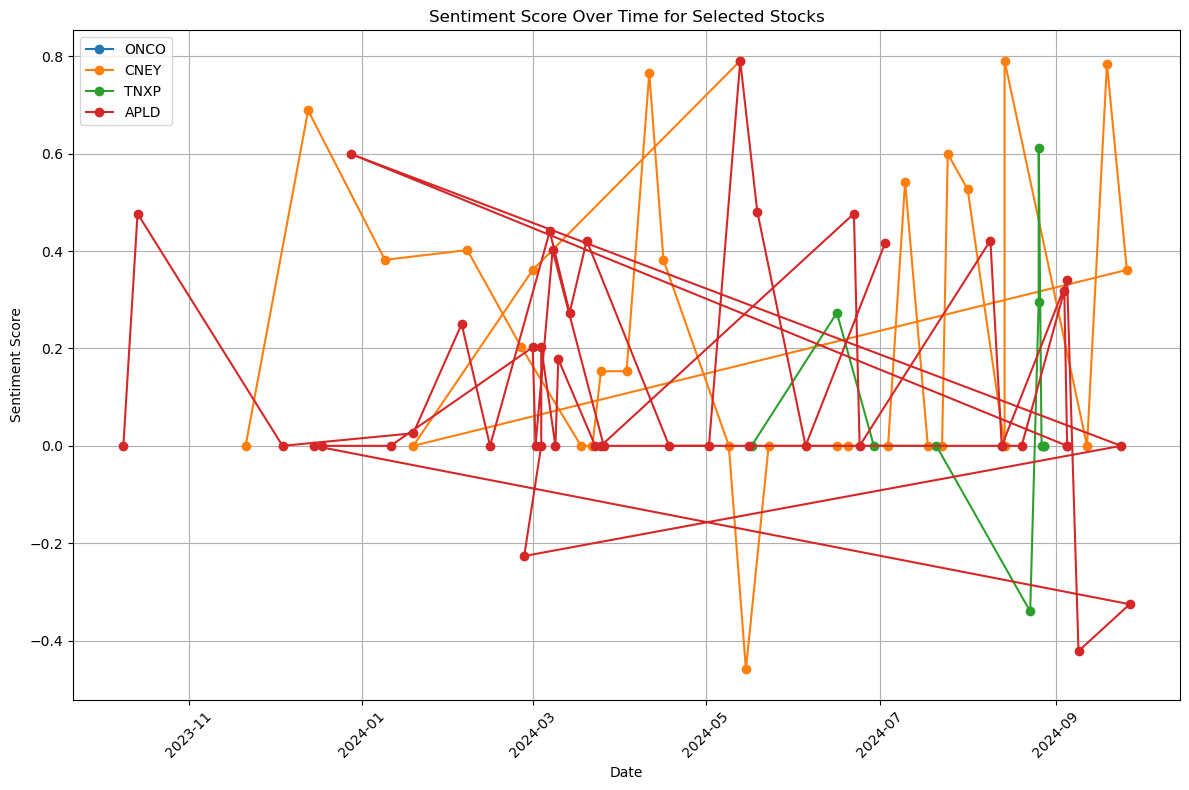

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from CSV files
onco_data = pd.read_csv('/users/hm4th/stock-competition/ONCO_reddit_sentiment.csv')
cney_data = pd.read_csv('/users/hm4th/stock-competition/CNEY_reddit_sentiment.csv')
tnxp_data = pd.read_csv('/users/hm4th/stock-competition/TNXP_reddit_sentiment.csv')
apld_data = pd.read_csv('/users/hm4th/stock-competition/APLD_reddit_sentiment.csv')

# Calculate average sentiment scores
avg_sentiment = {
    'ONCO': onco_data['sentiment_score'].mean(),
    'CNEY': cney_data['sentiment_score'].mean(),
    'TNXP': tnxp_data['sentiment_score'].mean(),
    'APLD': apld_data['sentiment_score'].mean()
}

print("Average Sentiment Scores:")
for stock, score in avg_sentiment.items():
    print(f"{stock}: {score:.4f}")

# Convert 'created_utc' column to datetime format for each DataFrame
onco_data['created_utc'] = pd.to_datetime(onco_data['created_utc'])
cney_data['created_utc'] = pd.to_datetime(cney_data['created_utc'])
tnxp_data['created_utc'] = pd.to_datetime(tnxp_data['created_utc'])
apld_data['created_utc'] = pd.to_datetime(apld_data['created_utc'])

# Plot sentiment scores over time for each stock
plt.figure(figsize=(12, 8))

# Plot ONCO
plt.plot(onco_data['created_utc'], onco_data['sentiment_score'], label='ONCO', marker='o')

# Plot CNEY
plt.plot(cney_data['created_utc'], cney_data['sentiment_score'], label='CNEY', marker='o')

# Plot TNXP
plt.plot(tnxp_data['created_utc'], tnxp_data['sentiment_score'], label='TNXP', marker='o')

# Plot APLD
plt.plot(apld_data['created_utc'], apld_data['sentiment_score'], label='APLD', marker='o')

# Formatting the plot
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score Over Time for Selected Stocks')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
#To complete your task, I'll guide you through building a binary classification model using logistic regression 
#and other machine learning methods. We'll use data from NewsAPI, FRED API, and Reddit API to create a time-series 
#dataset with sentiment analysis and economic indicators for stock prediction.

In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from newsapi.newsapi_client import NewsApiClient
from fredapi import Fred
import praw
import requests
from datetime import datetime, timedelta


In [47]:
# Load CSV files
# Load data from CSV files
onco_data = pd.read_csv('/users/hm4th/stock-competition/ONCO_reddit_sentiment.csv')
cney_data = pd.read_csv('/users/hm4th/stock-competition/CNEY_reddit_sentiment.csv')
tnxp_data = pd.read_csv('/users/hm4th/stock-competition/TNXP_reddit_sentiment.csv')
apld_data = pd.read_csv('/users/hm4th/stock-competition/APLD_reddit_sentiment.csv')
sentiment_data = pd.read_csv('/users/hm4th/desktop/stock_sentiment_analysis_with_date.csv')
macro_data = pd.read_csv('/users/hm4th/desktop/macro_economic_data.csv')
technical_indicators = pd.read_csv('/users/hm4th/desktopfinal_technical_indicators_dataset.csv')


In [48]:
newsapi = NewsApiClient(api_key='d4f5a637a7f54525bf11236c368f7561')

# Function to fetch news data
def fetch_news_data(query, from_date, to_date):
    all_articles = newsapi.get_everything(q=query,
                                          from_param=from_date,
                                          to=to_date,
                                          language='en',
                                          sort_by='relevancy',
                                          page_size=100)
    articles = all_articles['articles']
    news_data = pd.DataFrame(articles)
    return news_data[['publishedAt', 'title', 'description', 'content']]

# Example of fetching data for the past week
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=7)).strftime('%Y-%m-%d')
news_data = fetch_news_data('stock market', start_date, end_date)
news_data['date'] = pd.to_datetime(news_data['publishedAt']).dt.date


In [49]:
fred = Fred(api_key='c25b738d4b0b4944087469f21ab02241')

# Example of fetching economic data
gdp_data = fred.get_series('GDP')
gdp_data = gdp_data.reset_index()
gdp_data.columns = ['date', 'gdp']


In [50]:
reddit = praw.Reddit(
    client_id='q3ITcZIpdaKp5qPp4jTDvA', 
    client_secret='0IdN55fK-0T9uzLpxb9CV3d_DfguCg', 
    user_agent='red_data'
)

# Function to fetch Reddit data
def fetch_reddit_data(subreddit, limit=100):
    posts = []
    for submission in reddit.subreddit(subreddit).top(limit=limit):
        posts.append([submission.created_utc, submission.title, submission.selftext])
    reddit_data = pd.DataFrame(posts, columns=['created_utc', 'title', 'selftext'])
    reddit_data['date'] = pd.to_datetime(reddit_data['created_utc'], unit='s').dt.date
    return reddit_data

reddit_data = fetch_reddit_data('stocks', limit=100)


In [ ]:
# Part 1: Fetch and Save Reddit Sentiment Data
import praw
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import datetime
import os

# Initialize PRAW (Reddit API) and VADER (Sentiment Analysis)
reddit = praw.Reddit(
    client_id='your_client_id', 
    client_secret='your_client_secret', 
    user_agent='your_user_agent'
)

analyzer = SentimentIntensityAnalyzer()

# Define the list of stocks and subreddits
stocks = {
    '$ONCO': 'OncoSec Medical',
    '$CNEY': 'CN Energy',
    '$TNXP': 'Tonix Pharmaceuticals',
    '$APLD': 'Applied Digital',
    '$KTTA': 'Pasithea Therapeutics'
}
subreddits = ['wallstreetbets', 'stocks', 'investing', 'pennystocks']



In [60]:
# Define the output folder - adjust path if on Windows
desktop_path = os.path.expanduser("~/Desktop")
output_folder = os.path.join(desktop_path, "stock_reddit_sentiments")

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Function to fetch and analyze sentiment for Reddit posts
def fetch_and_analyze_reddit_posts(stock_name, limit=50, time_filter='year'):
    posts = []
    for subreddit in subreddits:
        for submission in reddit.subreddit(subreddit).search(stock_name, sort='new', time_filter=time_filter, limit=limit):
            post = {
                'title': submission.title,
                'score': submission.score,
                'comments': submission.num_comments,
                'created_utc': datetime.datetime.fromtimestamp(submission.created_utc).strftime('%Y-%m-%d'),
                'selftext': submission.selftext,
                'permalink': submission.permalink
            }
            # Sentiment analysis using VADER
            sentiment = analyzer.polarity_scores(post['title'])
            post['sentiment_score'] = sentiment['compound']
            post['sentiment_positive'] = sentiment['pos']
            post['sentiment_negative'] = sentiment['neg']
            post['sentiment_neutral'] = sentiment['neu']
            posts.append(post)
    return posts

# Fetch Reddit data and perform sentiment analysis for all stocks
reddit_data = {}
for stock_symbol, stock_name in stocks.items():
    reddit_data[stock_symbol] = fetch_and_analyze_reddit_posts(stock_name)
    
    if len(reddit_data[stock_symbol]) > 0:
        df = pd.DataFrame(reddit_data[stock_symbol])
        csv_file_path = os.path.join(output_folder, f"{stock_symbol[1:]}_reddit_sentiment.csv")
        df.to_csv(csv_file_path, index=False)
        print(f"Saved {stock_symbol} data to CSV at {csv_file_path}.")
    else:
        print(f"No data for {stock_symbol}, skipping CSV saving.")

# Part 2: Load, Merge, and Prepare Data for Machine Learning
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report




Saved $ONCO data to CSV at /Users/hm4th/Desktop/stock_reddit_sentiments/ONCO_reddit_sentiment.csv.
Saved $CNEY data to CSV at /Users/hm4th/Desktop/stock_reddit_sentiments/CNEY_reddit_sentiment.csv.
Saved $TNXP data to CSV at /Users/hm4th/Desktop/stock_reddit_sentiments/TNXP_reddit_sentiment.csv.
Saved $APLD data to CSV at /Users/hm4th/Desktop/stock_reddit_sentiments/APLD_reddit_sentiment.csv.
No data for $KTTA, skipping CSV saving.


In [63]:
# Step 1: Load all datasets
stock_data = pd.read_csv('/Users/hm4th/Desktop/stock_prices.csv')
sentiment_data = pd.read_csv(f"{output_folder}/stock_sentiment_analysis.csv")
macro_data = pd.read_csv('macro_economic_data.csv')
technical_indicators_apld = pd.read_csv('APLD_technical_indicators.csv')
technical_indicators_cney = pd.read_csv('CNEY_technical_indicators.csv')
technical_indicators_onco = pd.read_csv('ONCO_technical_indicators.csv')
technical_indicators_tnxp = pd.read_csv('TNXP_technical_indicators.csv')

# Step 2: Clean and Prepare Data
# Convert date columns to datetime format
for df in [stock_data, sentiment_data, macro_data, technical_indicators_apld, technical_indicators_cney, technical_indicators_onco, technical_indicators_tnxp]:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df.dropna(subset=['date'], inplace=True)

# Step 3: Merge all datasets on 'date'
merged_data = stock_data.merge(sentiment_data, on='date', how='left') \
                        .merge(macro_data, on='date', how='left') \
                        .merge(technical_indicators_apld, on='date', how='left') \
                        .merge(technical_indicators_cney, on='date', how='left') \
                        .merge(technical_indicators_onco, on='date', how='left') \
                        .merge(technical_indicators_tnxp, on='date', how='left')

# Step 4: Feature Engineering - e.g., creating a target variable for stock price movement
merged_data['price_change'] = merged_data['close'].pct_change()
merged_data['target'] = np.where(merged_data['price_change'] > 0, 1, 0)  # 1 for positive change, 0 for negative/neutral

# Step 5: Prepare Data for Machine Learning
# Fill NaN values with mean
merged_data.fillna(merged_data.mean(), inplace=True)

# Define features and target
features = merged_data.drop(columns=['target', 'price_change', 'date', 'close'])  # adjust based on your column names
target = merged_data['target']



FileNotFoundError: [Errno 2] No such file or directory: '/Users/hm4th/Desktop/stock_reddit_sentiments/stock_sentiment_analysis.csv'

In [78]:
import pandas as pd
import os

# Define the directory where the sentiment files are located
output_folder = '/Users/hm4th/Desktop/stock_reddit_sentiments'

# List of sentiment files to load and concatenate
sentiment_files = ['TNXP_reddit_sentiment.csv', 'APLD_reddit_sentiment.csv', 
                   'CNEY_reddit_sentiment.csv', 'ONCO_reddit_sentiment.csv']

# Load and concatenate all sentiment data into a single DataFrame
sentiment_data_list = [pd.read_csv(f"{output_folder}/{file}") for file in sentiment_files]
sentiment_data = pd.concat(sentiment_data_list, ignore_index=True)

# Proceed with the rest of your code, such as merging with other datasets
# Step 1: Load all datasets (ensure paths are correct for each file)
stock_data = pd.read_csv('/Users/hm4th/Desktop/stock_prices.csv')
macro_data = pd.read_csv('/Users/hm4th/Desktop/macro_economic_data.csv')
technical_indicators_apld = pd.read_csv('/Users/hm4th/Desktop/APLD_technical_indicators.csv')
technical_indicators_cney = pd.read_csv('/Users/hm4th/Desktop/CNEY_technical_indicators.csv')
technical_indicators_onco = pd.read_csv('/Users/hm4th/Desktop/ONCO_technical_indicators.csv')
technical_indicators_tnxp = pd.read_csv('/Users/hm4th/Desktop/TNXP_technical_indicators.csv')





In [82]:
# Step 2: Convert 'Date' columns to lowercase 'date', add placeholder if missing, then convert to datetime without timezone
for df in [stock_data, sentiment_data, macro_data, technical_indicators_apld, 
           technical_indicators_cney, technical_indicators_onco, technical_indicators_tnxp]:
    # Rename 'Date' to 'date' if it exists
    if 'Date' in df.columns:
        df.rename(columns={'Date': 'date'}, inplace=True)
    # Add a placeholder 'date' column if missing
    if 'date' not in df.columns:
        df['date'] = pd.NaT  # Placeholder NaT (Not-a-Time) column for easier handling
        print("Added placeholder 'date' column for DataFrame.")
    # Convert 'date' to datetime where it exists, forcing any existing non-date formats to be coerced
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    # Remove timezone information by converting to naive datetime
    df['date'] = df['date'].dt.tz_localize(None)
    df.dropna(subset=['date'], inplace=True)  # Drop rows where 'date' is NaT



In [84]:
# Function to rename columns with a prefix
def rename_columns(df, prefix):
    df = df.rename(columns=lambda x: f"{prefix}_{x}" if x != 'date' else x)
    return df

# Rename columns
technical_indicators_apld = rename_columns(technical_indicators_apld, 'APLD')
technical_indicators_cney = rename_columns(technical_indicators_cney, 'CNEY')
technical_indicators_onco = rename_columns(technical_indicators_onco, 'ONCO')
technical_indicators_tnxp = rename_columns(technical_indicators_tnxp, 'TNXP')

# Merge all datasets on 'date'
merged_data = stock_data.merge(sentiment_data, on='date', how='left') \
                        .merge(macro_data, on='date', how='left') \
                        .merge(technical_indicators_apld, on='date', how='left') \
                        .merge(technical_indicators_cney, on='date', how='left') \
                        .merge(technical_indicators_onco, on='date', how='left') \
                        .merge(technical_indicators_tnxp, on='date', how='left')


In [89]:
# Step 4: Feature Engineering
# Replace 'APLD_Close' with the relevant stock's close column, such as 'CNEY_Close' or 'ONCO_Close'
# For this example, I'll use 'APLD_Close'. Modify as needed.

# Assuming you want to calculate price change based on APLD's close price
merged_data['price_change'] = merged_data['APLD_Close'].pct_change()
merged_data['target'] = np.where(merged_data['price_change'] > 0, 1, 0)  # 1 for positive change, 0 for negative/neutral

# Step 5: Prepare Data for Machine Learning
# Fill NaN values with the mean
merged_data.fillna(merged_data.mean(), inplace=True)

# Define features and target for ML models
# Exclude the specific close column used and other unnecessary columns
features = merged_data.drop(columns=['target', 'price_change', 'date', 'APLD_Close'])  # Modify 'APLD_Close' as needed
target = merged_data['target']


In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Load all datasets
# Adjust the file paths as necessary
stock_data = pd.read_csv('/Users/hm4th/Documents/stock_prices.csv')
sentiment_data = pd.read_csv('/Users/hm4th/Desktop/merged_stock_sentiment_data.csv')
macro_data = pd.read_csv('/Users/hm4th/Documents/macro_economic_data.csv')
technical_indicators_apld = pd.read_csv('/Users/hm4th/Documents/APLD_technical_indicators.csv')
technical_indicators_cney = pd.read_csv('/Users/hm4th/Documents/CNEY_technical_indicators.csv')
technical_indicators_onco = pd.read_csv('/Users/hm4th/Documents/ONCO_technical_indicators.csv')
technical_indicators_tnxp = pd.read_csv('/Users/hm4th/Documents/TNXP_technical_indicators.csv')




In [12]:
# Rename 'Date' to 'date' and convert to timezone-naive datetime64[ns]
for df in datasets:
    if 'Date' in df.columns:
        df.rename(columns={'Date': 'date'}, inplace=True)
    
    # Convert to datetime with errors coerced to NaT (removes problematic entries)
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    
    # Remove timezone information, if any
    if df['date'].dt.tz is not None:
        df['date'] = df['date'].dt.tz_localize(None)

# Step 2: Verify no timezone and no 'object' types in 'date' before merging
for df in datasets:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')  # Ensure correct format

# Step 3: Merge all datasets on 'date' with suffixes for duplicate column names
merged_data = stock_data.merge(sentiment_data, on='date', how='left', suffixes=('', '_sentiment')) \
                        .merge(macro_data, on='date', how='left') \
                        .merge(technical_indicators_apld, on='date', how='left', suffixes=('', '_apld')) \
                        .merge(technical_indicators_cney, on='date', how='left', suffixes=('', '_cney')) \
                        .merge(technical_indicators_onco, on='date', how='left', suffixes=('', '_onco')) \
                        .merge(technical_indicators_tnxp, on='date', how='left', suffixes=('', '_tnxp'))

print("Merge completed successfully.")

Merge completed successfully.


In [16]:
# Print out all column names to locate the close price column for APLD
print("Available columns in merged_data:", merged_data.columns)

# Step 4: Feature Engineering
# Attempt to locate the correct column for APLD's close price
price_column = [col for col in merged_data.columns if 'Close' in col and 'APLD' in col]

if price_column:
    price_column = price_column[0]  # Use the first matching column
    merged_data['price_change'] = merged_data[price_column].pct_change()
    merged_data['target'] = np.where(merged_data['price_change'] > 0, 1, 0)  # 1 for positive change, 0 otherwise
    print(f"Using '{price_column}' as the close price column for APLD.")
else:
    # Provide more information if the column isn't found
    raise KeyError("APLD_Close or a similar column not found in merged_data. Please check column names.")

# Step 5: Prepare Data for Machine Learning
# Fill NaN values in numeric columns only
numeric_cols = merged_data.select_dtypes(include=['number']).columns
merged_data[numeric_cols] = merged_data[numeric_cols].fillna(merged_data[numeric_cols].mean())

# Define features and target for ML models
# Exclude 'date', 'price_change', and the column used for price calculation
features = merged_data.drop(columns=['target', 'price_change', 'date', price_column])
target = merged_data['target']

# Optional: Check the first few rows of features and target to verify
print(features.head())
print(target.head())


Available columns in merged_data: Index(['date', 'ONCO', 'CNEY', 'TNXP', 'APLD', 'KTTA', 'ONCO_sentiment',
       'CNEY_sentiment', 'TNXP_sentiment', 'APLD_sentiment', 'KTTA_sentiment',
       'title', 'description', 'content', 'author', 'source',
       'sentiment_score', 'sentiment_positive', 'sentiment_negative',
       'sentiment_neutral', 'significance', 'published_at', 'Interest_Rate',
       'GDP', 'Unemployment_Rate', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Dividends', 'Stock Splits', 'MA50', 'MA200', 'RSI', 'Volatility',
       'Open_cney', 'High_cney', 'Low_cney', 'Close_cney', 'Volume_cney',
       'Dividends_cney', 'Stock Splits_cney', 'MA50_cney', 'MA200_cney',
       'RSI_cney', 'Volatility_cney', 'Open_onco', 'High_onco', 'Low_onco',
       'Close_onco', 'Volume_onco', 'Dividends_onco', 'Stock Splits_onco',
       'MA50_onco', 'MA200_onco', 'RSI_onco', 'Volatility_onco', 'Open_tnxp',
       'High_tnxp', 'Low_tnxp', 'Close_tnxp', 'Volume_tnxp', 'Dividends_tnxp',

KeyError: 'APLD_Close or a similar column not found in merged_data. Please check column names.'

In [17]:
# Step 4: Feature Engineering
# First, we’ll try to locate 'APLD_Close' or similar, else use 'Close'
price_column = [col for col in merged_data.columns if 'Close' in col and 'APLD' in col]

if price_column:
    price_column = price_column[0]  # Use the found APLD-specific column
elif 'Close' in merged_data.columns:
    price_column = 'Close'  # Fallback to a generic 'Close' column
    print("Using the generic 'Close' column for price calculations.")
else:
    raise KeyError("Neither 'APLD_Close' nor a generic 'Close' column was found in merged_data. Please verify your data.")

merged_data['price_change'] = merged_data[price_column].pct_change()
merged_data['target'] = np.where(merged_data['price_change'] > 0, 1, 0)  # 1 for positive change, 0 otherwise

# Step 5: Prepare Data for Machine Learning
# Fill NaN values in numeric columns only
numeric_cols = merged_data.select_dtypes(include=['number']).columns
merged_data[numeric_cols] = merged_data[numeric_cols].fillna(merged_data[numeric_cols].mean())

# Define features and target for ML models
# Exclude 'date', 'price_change', and the column used for price calculation
features = merged_data.drop(columns=['target', 'price_change', 'date', price_column])
target = merged_data['target']

# Optional: Check the first few rows of features and target to verify
print(features.head())
print(target.head())


Using the generic 'Close' column for price calculations.
          ONCO       CNEY    TNXP     APLD       KTTA  ONCO_sentiment  \
0  2296.000000  55.200001  1152.0  4.26842  21.799999        4.665786   
1  2278.800049  57.599998  1152.0  4.26842  20.799999        4.665786   
2  1992.000000  60.299999  1088.0  4.26842  20.400000        4.665786   
3  1712.199951  56.400002  1152.0  4.26842  19.400000        4.665786   
4  1774.000000  56.400002  1152.0  4.26842  20.400000        4.665786   

   CNEY_sentiment  TNXP_sentiment  APLD_sentiment  KTTA_sentiment  ...  \
0          0.4395            0.16        5.662679        4.336268  ...   
1          0.4395            0.16        5.662679        4.336268  ...   
2          0.4395            0.16        5.662679        4.336268  ...   
3          0.4395            0.16        5.662679        4.336268  ...   
4          0.4395            0.16        5.662679        4.336268  ...   

  High_tnxp  Low_tnxp Close_tnxp   Volume_tnxp Dividends_tn

In [19]:
# Step 5: Prepare Data for Machine Learning
# Fill NaN values in numeric columns only
numeric_cols = merged_data.select_dtypes(include=['number']).columns
merged_data[numeric_cols] = merged_data[numeric_cols].fillna(merged_data[numeric_cols].mean())

# Define features and target for ML models
# Remove non-numeric columns from 'features'
features = merged_data[numeric_cols].drop(columns=['target', 'price_change'], errors='ignore')
target = merged_data['target']

# Ensure 'features' contains only numeric data
print("Columns in features before filtering numeric data:", features.columns)
features = features.apply(pd.to_numeric, errors='coerce')  # Convert all to numeric, setting errors to NaN for non-convertible values
features = features.fillna(0)  # Fill any remaining NaN values
print("Columns in features after filtering numeric data:", features.columns)

# Proceed with model training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Logistic Regression Model
log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
log_reg_model.fit(X_train, y_train)
y_pred_log = log_reg_model.predict(X_test)

# Random Forest Classifier Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Model Evaluation
# Logistic Regression Evaluation
print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Classification Report:\n", classification_report(y_test, y_pred_log))

# Random Forest Classifier Evaluation
print("\nRandom Forest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Columns in features before filtering numeric data: Index(['ONCO', 'CNEY', 'TNXP', 'APLD', 'KTTA', 'ONCO_sentiment',
       'CNEY_sentiment', 'TNXP_sentiment', 'APLD_sentiment', 'KTTA_sentiment',
       'sentiment_score', 'sentiment_positive', 'sentiment_negative',
       'sentiment_neutral', 'Interest_Rate', 'GDP', 'Unemployment_Rate',
       'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'MA50', 'MA200', 'RSI', 'Volatility', 'Open_cney', 'High_cney',
       'Low_cney', 'Close_cney', 'Volume_cney', 'Dividends_cney',
       'Stock Splits_cney', 'MA50_cney', 'MA200_cney', 'RSI_cney',
       'Volatility_cney', 'Open_onco', 'High_onco', 'Low_onco', 'Close_onco',
       'Volume_onco', 'Dividends_onco', 'Stock Splits_onco', 'MA50_onco',
       'MA200_onco', 'RSI_onco', 'Volatility_onco', 'Open_tnxp', 'High_tnxp',
       'Low_tnxp', 'Close_tnxp', 'Volume_tnxp', 'Dividends_tnxp',
       'Stock Splits_tnxp', 'MA50_tnxp', 'MA200_tnxp', 'RSI_tnxp',
       'Volatilit

/Library/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Re-train the models with balanced data
log_reg_model.fit(X_train_balanced, y_train_balanced)
y_pred_log_balanced = log_reg_model.predict(X_test)

rf_model.fit(X_train_balanced, y_train_balanced)
y_pred_rf_balanced = rf_model.predict(X_test)

# Evaluate the Logistic Regression model
print("Balanced Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_log_balanced))
print("Classification Report:\n", classification_report(y_test, y_pred_log_balanced))

# Evaluate the Random Forest model
print("\nBalanced Random Forest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf_balanced))
print("Classification Report:\n", classification_report(y_test, y_pred_rf_balanced))


ImportError: cannot import name '_MissingValues' from 'sklearn.utils._param_validation' (/Library/anaconda3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py)

In [21]:
# Logistic Regression with class weights
log_reg_model_weighted = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
log_reg_model_weighted.fit(X_train, y_train)
y_pred_log_weighted = log_reg_model_weighted.predict(X_test)

# Random Forest with class weights
rf_model_weighted = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model_weighted.fit(X_train, y_train)
y_pred_rf_weighted = rf_model_weighted.predict(X_test)

# Evaluate the Logistic Regression model with class weights
print("Weighted Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_log_weighted))
print("Classification Report:\n", classification_report(y_test, y_pred_log_weighted))

# Evaluate the Random Forest model with class weights
print("\nWeighted Random Forest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf_weighted))
print("Classification Report:\n", classification_report(y_test, y_pred_rf_weighted))


Weighted Logistic Regression Results:
Accuracy: 0.841726618705036
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90       125
           1       0.38      0.93      0.54        14

    accuracy                           0.84       139
   macro avg       0.69      0.88      0.72       139
weighted avg       0.93      0.84      0.87       139


Weighted Random Forest Results:
Accuracy: 0.9064748201438849
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95       125
           1       0.57      0.29      0.38        14

    accuracy                           0.91       139
   macro avg       0.75      0.63      0.67       139
weighted avg       0.89      0.91      0.89       139



In [ ]:
'''
Analysis of the Results:
Logistic Regression (Weighted):

High recall for the minority class (93%), but lower precision (38%).
This means the model correctly identifies most of the actual class 1 samples but has some false positives.
Random Forest (Weighted):

Better accuracy overall, but recall for class 1 remains low at 29%.
This suggests Random Forest may still be favoring the majority class, even with weights applied.

'''

In [22]:
# Adjust class weights manually for Logistic Regression
log_reg_model_custom = LogisticRegression(max_iter=1000, random_state=42, class_weight={0: 1, 1: 5})
log_reg_model_custom.fit(X_train, y_train)
y_pred_log_custom = log_reg_model_custom.predict(X_test)
print("Custom Weighted Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_log_custom))
print("Classification Report:\n", classification_report(y_test, y_pred_log_custom))

# Adjust class weights manually for Random Forest
rf_model_custom = RandomForestClassifier(n_estimators=100, random_state=42, class_weight={0: 1, 1: 5})
rf_model_custom.fit(X_train, y_train)
y_pred_rf_custom = rf_model_custom.predict(X_test)
print("\nCustom Weighted Random Forest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf_custom))
print("Classification Report:\n", classification_report(y_test, y_pred_rf_custom))


Custom Weighted Logistic Regression Results:
Accuracy: 0.8489208633093526
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91       125
           1       0.39      0.93      0.55        14

    accuracy                           0.85       139
   macro avg       0.69      0.88      0.73       139
weighted avg       0.93      0.85      0.87       139


Custom Weighted Random Forest Results:
Accuracy: 0.9064748201438849
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95       125
           1       0.57      0.29      0.38        14

    accuracy                           0.91       139
   macro avg       0.75      0.63      0.67       139
weighted avg       0.89      0.91      0.89       139



In [23]:
from sklearn.ensemble import GradientBoostingClassifier
gbc_model = GradientBoostingClassifier(random_state=42)
gbc_model.fit(X_train, y_train)
y_pred_gbc = gbc_model.predict(X_test)
print("Gradient Boosting Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_gbc))
print("Classification Report:\n", classification_report(y_test, y_pred_gbc))


Gradient Boosting Results:
Accuracy: 0.9280575539568345
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       125
           1       0.75      0.43      0.55        14

    accuracy                           0.93       139
   macro avg       0.84      0.71      0.75       139
weighted avg       0.92      0.93      0.92       139



In [24]:
# Predict probabilities instead of class labels
y_pred_prob = log_reg_model_custom.predict_proba(X_test)[:, 1]
# Adjust the threshold (for example, 0.3)
y_pred_custom_threshold = (y_pred_prob >= 0.3).astype(int)
print("Threshold Adjusted Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_custom_threshold))
print("Classification Report:\n", classification_report(y_test, y_pred_custom_threshold))


Threshold Adjusted Logistic Regression Results:
Accuracy: 0.841726618705036
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90       125
           1       0.38      0.93      0.54        14

    accuracy                           0.84       139
   macro avg       0.69      0.88      0.72       139
weighted avg       0.93      0.84      0.87       139

